<a href="https://colab.research.google.com/github/gsidorov/fastai.practice/blob/master/nn_training_eswiki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turkish ULMFiT from scratch

In [1]:
!nvidia-smi

Fri Aug 14 20:58:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !unzip ./drive/My\ Drive/es_databunch

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *

In [5]:
bs=256 ## crashes with 96, ok with 64, 82 -- But I see no improvement when I launch it with 82
torch.cuda.set_device(0)
data_path = Config.data_path()

lang = 'es'
name = f'{lang}wiki'
# path = data_path/name
# path.mkdir(exist_ok=True, parents=True)

In [6]:
path = pathlib.Path('/content/archive')
path.mkdir(exist_ok=True, parents=True)

Batch size = 82
![image.png](attachment:52099c79-07a0-431a-9e73-acbbb4c7f071.png)

In [7]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [11]:
# data_path = Config.data_path()
# data_path

In [8]:
mdl_path = path/'models'

In [9]:
# !mkdir .

In [10]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
lm_fns = [mdl_path/f'{lang}_wt', mdl_path/f'{lang}_wt_vocab']

## Turkish wikipedia model

Turkish is an [Agglutinative_language](https://en.wikipedia.org/wiki/Agglutinative_language) so it needs special care!

![Turkish morphemes example](images/turkish.jpg)

In [15]:
# data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor()])
#         .split_by_rand_pct(0.1, seed=42)
#         .label_for_lm()
#         .databunch(bs=bs, num_workers=4))

In [16]:
# # data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor()])
# #         .split_by_rand_pct(0.1, seed=42)
# #         .label_for_lm()
# #         .databunch(bs=bs, num_workers=1))
# data.save(f'{lang}_databunch')
# len(data.vocab.itos),len(data.train_ds)

In [11]:
data = './drive/My Drive/es_databunch'

In [12]:
data = load_data(data,'', bs=bs)

In [13]:
# data

In [14]:
# data.show_batch()

In [15]:
data.path = path

In [16]:
data.path

PosixPath('/content/archive')

In [42]:
# learn.save_encoder('test_gleb_learn.saveecnoder')

#### Here I was testing what do we need to do to load a model, I understood a bit better that you get the architecture of the model by learn.export(), and then we weights we will be getting them by learn.save_encoders() which will be executed on every run. Then, another important thing is to load the data into the model

In [17]:
# pathlib.Path(path, 'models')

In [18]:
# learn = load_learner(pathlib.Path(path, 'models'), 'test_gleb_learn.saveecnoder.pth' )

In [19]:
# learn

In [20]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.1, wd=0.1, pretrained=False).to_fp16()

In [21]:
# !ls /content/archive/models

In [22]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

Checking the error that I was having:

/home/neuralcrypto/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.

Then looked it up on the github:

https://github.com/fastai/fastai/issues/2563

The solutions:

-switch to the fastai2 model
-pin PyTorch to 1.4.0
-ignore all warnings

//

And to avoid the warnings:

I tried running

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
But this still shows the same error, although the training seems to be progressing. I realized that I've written the wrong torch module, but which is the right module to add here? torch.autograd.backward?
Edit:

I think I solved it by running

 warning.filterwarning("ignore)

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [24]:
warnings.filterwarnings("ignore")

In [25]:
import datetime
start_training = datetime.datetime.now()

In [26]:
start_training

datetime.datetime(2020, 8, 14, 21, 1, 14, 806814)

In [27]:
# learn.export()

In [28]:
# learn.save_encoder('otrotest')

In [29]:
# learn.save_encoder('testing_encoder')

In [30]:
# learner_test = load_learner(pathlib.Path(path))

In [31]:
# learner_test

In [33]:
# learner_test.data = data

In [34]:
# learner_test.data

In [38]:
# Do not forget to import the callback function
from fastai.callbacks import SaveModelCallback
# Train with the callback function set to save weights every epoch
learn.fit_one_cycle(3, lr, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net')])

epoch,train_loss,valid_loss,accuracy,time
0,3.868093,4.082419,0.284904,1:26:25
1,3.610266,3.771550,0.312789,1:26:27
2,3.367578,3.337315,0.361218,1:26:39


In [39]:
from google.colab import files

def downloader_models():
  for i in os.listdir('./archive/models'):
    files.download('/content/archive/models/'+i)

def download_files_from_model():
  for i in os.listdir('./archive'):
    # We do not want to download the folder of the models as a folder
    if i == 'models': continue
    files.download('/content/archive/'+i)


In [40]:
downloader_models()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
learner.export()

NameError: ignored

In [2]:
download_files_from_model()

NameError: ignored

In [37]:
# learn.unfreeze()
# learn.fit_one_cycle(3, lr, moms=(0.8,0.7))

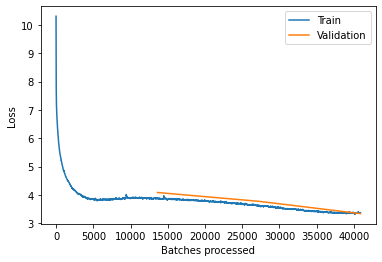

In [42]:
learn.recorder.plot_losses()

In [43]:
# learn.predict('hola como', 1)

In [44]:
learn

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (130128 items)
x: LMTextList
▁xxbos ▁xxmaj ▁ ú tica ▁xxmaj ▁ ú tica ▁fue ▁una ▁ciudad ▁del ▁norte ▁de ▁xxmaj ▁áfrica ▁que ▁estaba ▁situada ▁al ▁noroeste ▁de ▁xxmaj ▁cartago ▁en ▁el ▁actual ▁territorio ▁de ▁xxmaj ▁túnez ▁a ▁40 ▁km ▁al ▁noroeste ▁de ▁su ▁capital . ▁xxmaj ▁fue ▁la ▁capital ▁de ▁la ▁provincia ▁romana ▁de ▁xxmaj ▁áfrica ▁xxmaj ▁pro consul ar ▁entre ▁146 ▁a . ▁xxup ▁c . ▁y ▁25 . ▁xxmaj ▁en ▁la ▁actualidad ▁está ▁situada ▁a ▁8 ▁km ▁de ▁la ▁costa ▁y ▁se ▁pueden ▁apreciar ▁restos ▁de ▁sus ▁edificios ▁públicos ▁como ▁termas , ▁almacenes , ▁muelle s ▁y ▁un ▁anfiteatro ▁para ▁más ▁de ▁20 ▁000 ▁espectadores . ▁xxmaj ▁fue ▁fundada ▁por ▁los ▁fenicio s ▁hacia ▁el ▁año ▁11 01 ▁a . ▁xxup ▁c . , ▁según ▁xxmaj ▁plinio ▁el ▁xxmaj ▁viejo , ▁y ▁prosperó ▁hasta ▁convertirse ▁en ▁un ▁importante ▁puerto . ▁xxmaj ▁el ▁florecimiento ▁de ▁xxmaj ▁cartago ▁( fundada ▁según ▁la ▁leyenda ▁2 87 ▁años ▁después ) ▁e clip só ▁su ▁importancia . ▁xxma

In [45]:
finish_training = datetime.datetime.now()
print(finish_training)
print(f'{finish_training - start_training}')

2020-08-15 01:23:49.225977
4:22:34.419163


In [46]:
# learn.to_fp32().save(lm_fns[0], with_opt=False)
# learn.data.vocab.save(lm_fns[1].with_suffix('.pkl'))

In [47]:
print(f'the real time per cycle is {(finish_training - start_training) / 3}')

the real time per cycle is 1:27:31.473054


In [48]:
import time

In [1]:
for i in range(80000):
  time.sleep(15)
  print('i want to break free')

NameError: ignored

## Turkish sentiment analysis

https://www.win.tue.nl/~mpechen/projects/smm/

### Language model

In [ ]:
path_clas = path/'movies'
path_clas.ls()

[PosixPath('/home/sgugger/.fastai/data/trwiki/movies/tr_polarity.pos'),
 PosixPath('/home/sgugger/.fastai/data/trwiki/movies/tr_clas_databunch'),
 PosixPath('/home/sgugger/.fastai/data/trwiki/movies/models'),
 PosixPath('/home/sgugger/.fastai/data/trwiki/movies/tr_polarity.neg'),
 PosixPath('/home/sgugger/.fastai/data/trwiki/movies/tr_data_lm')]

In [ ]:
pos = (path_clas/'tr_polarity.pos').open(encoding='iso-8859-9').readlines()
pos_df = pd.DataFrame({'text':pos})
pos_df['pos'] = 1
pos_df.head()

,text,pos
0,gerçekten harika bir yapim birçok kez izledim ...,1
1,her izledigimde hayranlik duydugum gerçek klas...,1
2,gerçekten tarihi savas filmleri arasinda tarti...,1
3,aldigi ödülleri sonuna dek hak eden muhtesem b...,1
4,özgürlük denilince aklima gelen ilk film.bir b...,1


In [ ]:
neg = (path_clas/'tr_polarity.neg').open(encoding='iso-8859-9').readlines()
neg_df = pd.DataFrame({'text':neg})
neg_df['pos'] = 0
neg_df.head()

,text,pos
0,giseye oynayan bir film.mel gibson'in oyunculu...,0
1,bircok yonden sahip olduklari zayifliklari pop...,0
2,"1995 ten bu yana bu tür filmler artti , o zama...",0
3,mel gibson tam bir ingiliz düsmani her filmind...,0
4,milliyetçi bir film tavsiye etmiyorum.... \n,0


In [ ]:
df = pd.concat([pos_df,neg_df], sort=False)

In [ ]:
data_lm = (TextList.from_df(df, path_clas, cols='text', processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

data_lm.save(f'{lang}_clas_databunch')

In [ ]:
data_lm = load_data(path_clas, f'{lang}_clas_databunch', bs=bs)

In [ ]:
data_lm.show_batch()

idx,text
0,"▁bile ▁sinema ▁olgusu nun ▁en ▁üst ▁noktalar in dan . . ▁xxbos ▁gerçekten ▁tarihi ▁sava s ▁filmleri ▁ara si nda ▁tar tis ma siz ▁en ▁iyi si ▁ , ▁12 ▁ yi l ▁boyunca ▁ac aba ▁ikincisi ▁çek ir imi ▁diye ▁bekledi gi m ▁bir ▁film ▁ , bel ki ▁william ▁wallace ▁baba sinin ▁ölümünden ▁sonra ▁amca si ▁yani na ▁al m isti ▁onu ▁ ye tis tir m isti"
1,ka dra j lar i yla ▁konusu yla ▁is le ni siyle ▁insana ▁ iste ▁film ▁böyle ▁çekilir ▁de dir ten ▁kusur suz ▁bir ▁film . ▁xxbos ▁böyle ▁güzel ▁bir ▁yap it ▁olamaz ▁filmde ▁her ▁sey ▁var ▁insani ▁dünya dan ▁ali p ▁gö tür üyor ▁bask a ▁diyar lara ▁film ▁bitti kten ▁sonra ▁epey ▁süre ▁geçmesi ▁gerekiyor ▁tekrar ▁dünya ▁ya ▁dönmek ▁için ▁dikkat ! . ▁xxbos ▁inan ir mi siniz
2,▁o ▁kadar ▁etki len mis tim ▁ki . . . özellikle ▁özgürlük ▁ ug ru na ▁sava san ▁william ▁wallace  in ▁is ken ce ▁edilerek ▁idam ▁edilmesi . . . ve ▁sonunda ▁özgürlük ▁diye ▁hay kir isi . . . ha lan ▁unut ami yorum ▁xxrep ▁4 ▁ . ▁xxbos ▁ilk ▁bu ▁filmi ▁sinema da ▁izledi m ▁ve ▁insan in ▁inan di ktan ▁sonra ▁ ne leri ▁yap a
3,▁için ▁ister ▁istemez ▁oraya ▁gö tür üyor ▁filmin ▁uzun lu gun a ▁al dan ip ta ▁filmi ▁izlemek ten ▁vazgeçme yin ▁xxrep ▁4 ▁ . ▁xxbos ▁harika ▁bir ▁film di ▁xxrep ▁5 ▁ . ▁xxbos ▁mükemmel ▁ötesi . . ▁ . ▁xxbos ▁hiç ▁ a bart mi yorum ▁hayat im da ▁izledi gi m ▁en ▁iyi ▁film lerden ▁biri ▁diye bilir im . tam ▁bir ▁bas yap it ▁nite ligi
4,les iyor . ▁herkes ▁izleme li . . . ▁xxbos ▁tarantino nun ▁en ▁iyi ▁filmlerinden ▁biri . ▁diyalog lar ▁çok ▁iyi . ▁kesinlikle ▁izlenmesi ▁gereken ▁bir ▁film . . ▁xxbos ▁tarantino nun ▁bu ▁filmi ▁kendini ▁belli ▁etti r iyor . hat ta ▁ben ce ▁tarantino nun ▁en ▁iyi ▁filmidir . kendi ne ▁has ▁anlat imi ▁ile ▁bu ▁film ▁hak ka ten ▁sinema ▁sever lerin ▁izleme si ▁gereken ▁bir ▁film .


In [ ]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0, wd=0.1)

In [ ]:
lr = 1e-3
lr *= bs/48

In [ ]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,4.762205,4.132825,00:07


In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, slice(lr/10,lr*10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,4.136730,3.976010,00:08
1,3.991336,3.882426,00:08
2,3.768218,3.812365,00:08
3,3.526307,3.795765,00:08
4,3.310204,3.815228,00:08


In [ ]:
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

### Classifier

In [ ]:
data_clas = (TextList.from_df(df, path_clas, cols='text', processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='pos')
    .databunch(bs=bs, num_workers=1))

In [ ]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False, wd=0.1).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

In [ ]:
lr=2e-2
lr *= bs/48

In [ ]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.456195,0.441739,0.817073,00:02
1,0.416383,0.359390,0.841463,00:02


In [ ]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.413642,0.381773,0.828330,00:02
1,0.407912,0.358319,0.846154,00:02


In [ ]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.358337,0.310041,0.869606,00:02
1,0.279921,0.276278,0.892120,00:02


In [ ]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.258410,0.261940,0.899625,00:03
1,0.183993,0.267610,0.905253,00:02


In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(4, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.115543,0.290134,0.902439,00:03
1,0.107257,0.297127,0.911820,00:03


Accuracy in Gezici (2018), *Sentiment Analysis in Turkish* is: `75.16%`.

In [ ]:
learn_c.save(f'{lang}clas')

## fin